In [1]:
from mlxterp import InterpretableModel, interventions as iv
from mlx_lm import load
import mlx.core as mx
import mlx.nn as nn
from mlx_lm import generate
from mlx_lm.sample_utils import make_sampler

In [2]:
# 1. Create a simple model
class SimpleTransformer(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.layers = [
            nn.Linear(hidden_dim, hidden_dim) for _ in range(4)
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            x = nn.relu(x)
        return x


In [3]:
# 2. Wrap with InterpretableModel
base_model = SimpleTransformer()
model = InterpretableModel(base_model)

In [4]:
# 3. Create input
input_data = mx.random.normal((1, 10, 64))  # (batch, seq, hidden)

In [5]:
# 4. Trace execution
with model.trace(input_data):
    layer_0 = model.layers[0].output.save()
    layer_2 = model.layers[2].output.save()

In [6]:
print(f"Layer 0 shape: {layer_0.shape}")
print(f"Layer 2 shape: {layer_2.shape}")

Layer 0 shape: (1, 10, 64)
Layer 2 shape: (1, 10, 64)


In [7]:
output = model.model(input_data)  # Access the underlying base_model
print(f"Direct output: {output}")

# Option 3: Use base_model directly
output = base_model(input_data)
print(f"Base model output: {output.shape}")

Direct output: array([[[0.0467498, 0, 0.030843, ..., 0, 0, 0.0376398],
        [0.0891892, 0, 0.0192189, ..., 0.0205293, 0, 0.0154155],
        [0.102115, 0.0183368, 0, ..., 0.0889428, 0, 0.0289738],
        ...,
        [0.0496707, 0.014343, 0.0187814, ..., 0.0891296, 0, 0.00275697],
        [0.0704506, 0, 0.0450604, ..., 0.00953586, 0, 0.0218926],
        [0.025725, 0.0025534, 0.00608771, ..., 0, 0, 0.0324976]]], dtype=float32)
Base model output: (1, 10, 64)


# Load a real Model

In [2]:
#base_model, tokenizer = load("mlx-community/Llama-3.2-1B-Instruct-4bit")
#base_model, tokenizer = load("mlx-community/DeepSeek-R1-0528-Qwen3-8B-4bit-DWQ")
base_model, tokenizer = load("arogister/Qwen3-8B-ShiningValiant3-mlx-4Bit")
model = InterpretableModel(base_model, tokenizer=tokenizer)


Fetching 11 files: 100%|██████████| 11/11 [00:00<00:00, 146934.22it/s]


In [3]:
model.model

Model(
  (model): Qwen3Model(
    (embed_tokens): QuantizedEmbedding(151936, 4096, group_size=64, bits=4, mode=affine)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (q_proj): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4, mode=affine)
        (k_proj): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4, mode=affine)
        (v_proj): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4, mode=affine)
        (o_proj): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4, mode=affine)
        (q_norm): RMSNorm(128, eps=1e-06)
        (k_norm): RMSNorm(128, eps=1e-06)
        (rope): RoPE(128, traditional=False)
      )
      (mlp): MLP(
        (gate_proj): QuantizedLinear(input_dims=4096, output_dims=12288, bias=False, group_size=64, bits=4, mode=affine)
        (down_proj): QuantizedLinear(input_dims=12288, output_dims=4096, 

In [4]:

### Run it once to have full keys
print("Run it once to have full keys")
print("-"*100)
with model.trace("Hello, who are you?") as trace:
    pass
keys_list = list(trace.activations.keys())
for key in keys_list[-5:]:
    print(key)

### Run it twice and the keys are different
print("Run it twice and the keys are different")
print("-"*100)
with model.trace("Hello, who are you?") as trace:
    pass
keys_list = list(trace.activations.keys())
for key in keys_list[-5:]:
    print(key)


Run it once to have full keys
----------------------------------------------------------------------------------------------------
model.model.layers.35
model.model.norm
model.model
model.lm_head
__model_output__
Run it twice and the keys are different
----------------------------------------------------------------------------------------------------
model.model.layers.35
model.model.norm
model.model
model.lm_head
__model_output__


In [5]:
with model.trace("The capital of France is") as trace:
    layer_6_mlp = trace.activations["model.model.layers.6.mlp"]

hidden = layer_6_mlp[0, -1, :]
print(hidden.shape)

predictions = model.get_token_predictions(hidden, top_k=5)
for token_id in predictions:
    print(model.token_to_str(int(token_id)))

(4096,)
选�
章
 squ
 accrued
 sink


In [6]:
  # Your prompt
  prompt = "What is the issue if we ask which persons are living in the town where the eifeltower is. Which nationalities should the people have. The nationality is"

  # Apply chat template (IMPORTANT!)
  messages = [{"role": "user", "content": prompt}]
  formatted_prompt = tokenizer.apply_chat_template(
      messages,
      add_generation_prompt=True,
      tokenize=False  # Get string, not tokens
  )

  print("Formatted prompt:")
  print(formatted_prompt)
  print("\n" + "="*80 + "\n")

Formatted prompt:
<|im_start|>user
What is the issue if we ask which persons are living in the town where the eifeltower is. Which nationalities should the people have. The nationality is<|im_end|>
<|im_start|>assistant





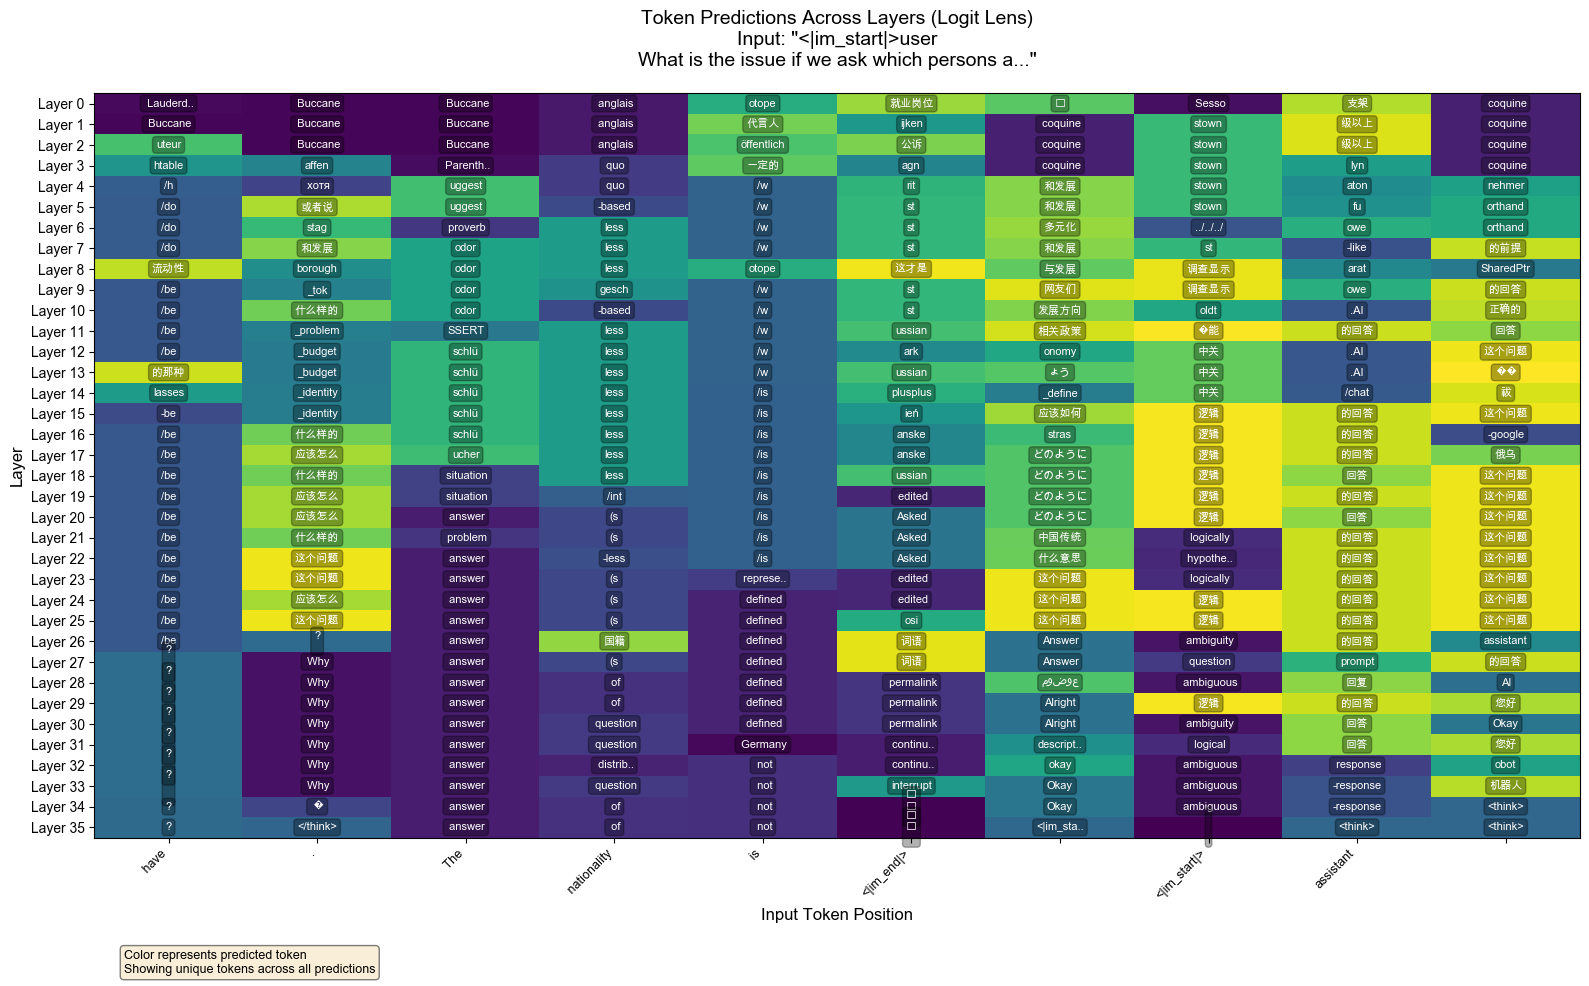

In [7]:
# Automamtic logit lens
results = model.logit_lens(formatted_prompt, plot=True, max_display_tokens=10, top_k=3)

In [7]:
  print("Top 10 predictions from logit lens (using formatted prompt):")
  for i, (token_id, score, token_str) in enumerate(results[47][-1], 1):
      print(f"  {i}. '{token_str}' (score: {score:.2f})")

Top 10 predictions from logit lens (using formatted prompt):
  1. 'Okay' (score: 38.97)
  2. 'We' (score: 30.94)
  3. 'Hmm' (score: 28.34)


In [8]:
for layer_idx in [10, 15]:
    print(f"\nLayer {layer_idx} - last position top 3:")
    last_pos_preds = results[layer_idx][-1]  # All predictions at last position

    for i, (token_id, score, token_str) in enumerate(last_pos_preds, 1):
        print(f"  {i}. '{token_str}' (score: {score:.2f})")


Layer 10 - last position top 3:
  1. 'إص' (score: 12.30)
  2. '봣' (score: 12.17)
  3. 'إنش' (score: 12.15)

Layer 15 - last position top 3:
  1. 'إنش' (score: 11.74)
  2. 'إص' (score: 10.97)
  3. '$__' (score: 10.76)


In [54]:
# Llayer, token position, token_id, logit/probability/term
results[47][-1][0][2]

'Okay'

In [8]:
sampler = make_sampler(temp=0.0)
# mlx-lm generate
prompt = "What is the issue if we ask which persons are living in the town where the eifeltower is. Which nationalities should the people have. The nationality is"

messages = [{"role": "user", "content": prompt}]
prompt = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)

text = generate(base_model, tokenizer, prompt=prompt, verbose=True, max_tokens=1, sampler=sampler)


<think>
Prompt: 41 tokens, 223.072 tokens-per-sec
Generation: 1 tokens, 22944.726 tokens-per-sec
Peak memory: 5.478 GB


# Layer by Layer Patching Analysis

Getting clean output...
Getting corrupted output...
Baseline mse distance: 0.7749

Patching self_attn at each layer...
  Layer 35...
Completed patching 36 layers


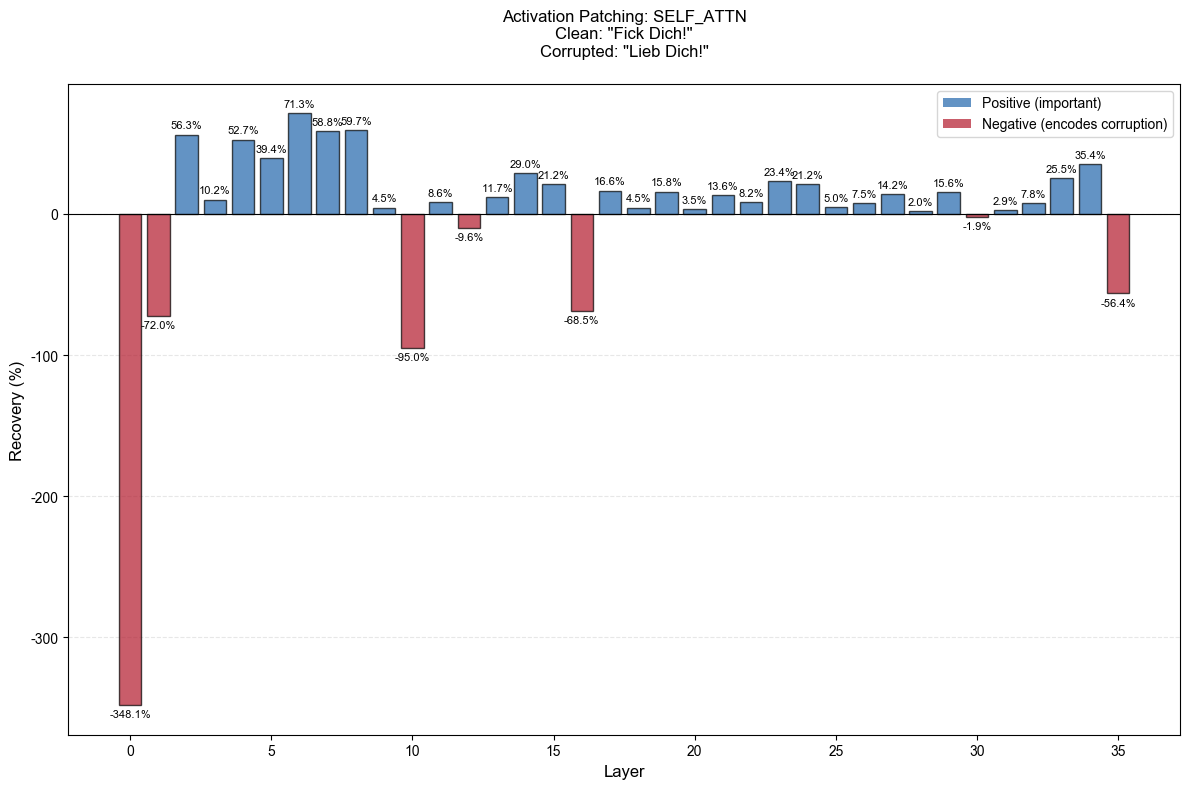

Top 3 most important layers:
  Layer 6: 71.3% recovery
  Layer 8: 59.7% recovery
  Layer 7: 58.8% recovery


In [9]:
# Find important layers - that's it!
results = model.activation_patching(
    clean_text="Fick Dich!",
    corrupted_text="Lieb Dich!",
    component="self_attn",
    metric="mse",
    plot=True
)

# Analyze
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("Top 3 most important layers:")
for layer_idx, recovery in sorted_results[:3]:
    print(f"  Layer {layer_idx}: {recovery:.1f}% recovery")

# Visualization

In [1]:
  from mlxterp import InterpretableModel
  from mlxterp.sae import visualize_feature_activations
  from mlx_lm import load

  # Load model and SAE
  mlx_model, tokenizer = load("arogister/Qwen3-8B-ShiningValiant3-mlx-4Bit")
  model = InterpretableModel(mlx_model, tokenizer=tokenizer)
  sae = model.load_sae("sae_layer23_mlp_10000samples.mlx")

  # Visualize - auto-detects Jupyter vs terminal
  visualize_feature_activations(
      model,
      "The Eiffel Tower is in Paris",
      sae,
      layer=23,
      component="mlp",
      top_k_features=3,
      show_values=True  # Also show numerical values
  )

/Users/sschacht/DevPlaygrounds/mlxTerp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 11 files: 100%|██████████| 11/11 [00:00<00:00, 166560.81it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()